In [2]:
import json
from matplotlib.font_manager import json_dump
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime
import seaborn as sns
import matplotlib.pylab as plt

sf_data = []
vicon_data = []

for line in open("../Dataset_sensor_floor/sensorfloor_measurement/sensor_floor_data_03082022_moving_around.txt", "r"):
    sf_data.append(json.loads(line))

df_sf = pd.DataFrame(sf_data)
df_sf

,timestamp,strip_id,node_id,data,column_num,ID
0,1.659534e+09,15,9,"[{'r': [-75], 'm': [81.45, 3.5999999999999996,...",15,1
1,1.659534e+09,5,13,"[{'r': [-93], 'm': [-15.299999999999999, 12.75...",5,1
2,1.659534e+09,1,10,"[{'r': [-70], 'm': [24.0, 11.25, 15.2999999999...",1,1
3,1.659534e+09,18,2,"[{'r': [-76], 'm': [147.45, 46.8, 105.0]}, {'r...",18,1
4,1.659534e+09,7,1,"[{'r': [-80], 'm': [106.2, 231.75, 51.44999999...",7,1
...,...,...,...,...,...,...
7932,1.659534e+09,1,11,"[{'r': [-66], 'm': [54.9, 7.199999999999999, -...",1,23
7933,1.659534e+09,22,3,"[{'r': [-81], 'm': [-74.39999999999999, -67.2,...",22,23
7934,1.659534e+09,17,6,"[{'r': [-68], 'm': [-44.1, -41.4, 51.3]}, {'r'...",17,23
7935,1.659534e+09,19,15,"[{'r': [-84], 'm': [-12.15, 16.349999999999998...",19,23


In [3]:
#1st option
df_sf_buf = df_sf.copy()
df_sf_buf = df_sf_buf.reindex(df_sf_buf.columns.tolist() + ['rssi','mx','my','mz'], axis=1) 

for index, row in df_sf_buf.T.items():
    rssi = []
    magneto = []
    for i in range(len(df_sf_buf['data'][index])):
        #print((test_df['data'][index][i]['r']))
        rssi.append(df_sf_buf['data'][index][i]['r'])
        magneto.append(df_sf_buf['data'][index][i]['m'])
    
    rssi_avg = np.mean(rssi, axis=0)
    magneto_avg = np.mean(magneto, axis=0)
    df_sf_buf.loc[index,'rssi'] = rssi_avg[0]
    df_sf_buf.loc[index,'mx']  = magneto_avg[0]
    df_sf_buf.loc[index,'my']  = magneto_avg[1]
    df_sf_buf.loc[index,'mz']  = magneto_avg[2]
    rssi.clear()
    magneto.clear()

df_sf_final = df_sf_buf.drop(columns=['data'])
df_sf_final

,timestamp,strip_id,node_id,column_num,ID,rssi,mx,my,mz
0,1.659534e+09,15,9,15,1,-74.578947,81.426316,3.836842,115.160526
1,1.659534e+09,5,13,5,1,-89.842105,-15.157895,12.615789,-86.068421
2,1.659534e+09,1,10,1,1,-70.210526,24.971053,11.171053,16.050000
3,1.659534e+09,18,2,18,1,-76.250000,146.235000,45.922500,104.415000
4,1.659534e+09,7,1,7,1,-80.833333,105.900000,229.058333,50.883333
...,...,...,...,...,...,...,...,...,...
7932,1.659534e+09,1,11,1,23,-66.000000,56.076316,7.744737,-36.836842
7933,1.659534e+09,22,3,22,23,-80.368421,-73.192105,-67.271053,60.394737
7934,1.659534e+09,17,6,17,23,-67.789474,-45.323684,-40.381579,52.231579
7935,1.659534e+09,19,15,19,23,-84.000000,-12.694737,15.600000,87.007895


In [17]:
df_sf_final.to_csv('sensorfloor_data_moving_around.csv')

In [ ]:
#Heatmap animation over the time
import matplotlib.animation as animation
%matplotlib ipympl
from matplotlib.widgets import Slider, Button, RadioButtons

#DEFINE DATASET ARRAY
x = df_sf_final['strip_id'].to_numpy()
y = df_sf_final['node_id'].to_numpy()
z = df_sf_final['rssi'].to_numpy()
t = df_sf_final['timestamp'].to_numpy()
dataSet = np.array([x, y, z, t])
numDataPoints = len(t)
num_of_nodes = 15
num_of_strips = 23
delta_t = round((t.max()-t.min())/numDataPoints, 6)

#CREATE 3D ARRAY FOR HEATMAP
rssi_mat = np.empty((numDataPoints,15,23))
#fig = plt.figure(figsize=(15, 9))

for index in range(numDataPoints):
    for node in range(num_of_nodes):
        for strip in range(num_of_strips):
            if node == int(dataSet[1][index])-1 and strip == int(dataSet[0][index])-1:
                rssi_mat[index][int(dataSet[1][index])-1][int(dataSet[0][index])-1] = (dataSet[2][index])
            else:
                rssi_mat[index][node][strip] = rssi_mat[index-1][node][strip]



#---------------------------------------------------------Heatmap with Slider---------------------------------------------------------------------#
# GET SOME MATPLOTLIB OBJECTS
fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(bottom=0.25)
#line = ax.plot(dataSet[0], dataSet[1], lw=2, c='g')[0] # For line plot
 
# AXES PROPERTIES
plt.title("RSSI Heatmap", fontsize = 16)
plt.ylabel("Node ID", fontsize = 16)
plt.xlabel("Strip ID", fontsize = 16)

#DISPLAY INITIAL IMAGE
#im_ax = sns.heatmap(rssi_mat[numDataPoints-1], annot=True, cbar_kws={'label': 'RSSI'}, cmap="YlGnBu")
im_h = ax.imshow(rssi_mat[numDataPoints-1], cmap="YlGnBu")
#cbar = fig.colorbar(im_h, ax=ax)
cbar = plt.colorbar(im_h)
cbar.set_label(label='RSSI (dBm)', size=16)
cbar.ax.tick_params(labelsize=12) 


# Defining the Slider button
# xposition, yposition, width and height
ax_slide = plt.axes([0.15, 0.15, 0.55, 0.03])

# Properties of the slider
timestamp = Slider(ax_slide, 'Timestamp (ms)',
                  t.min(), t.max(), valinit=t.min(), valstep=delta_t)
 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def update(val):
    pos = timestamp.val
    index = find_nearest(dataSet[3], pos)
    im_h.set_data(rssi_mat[index])
    
# Calling the function "update" when the value of the slider is changed
timestamp.on_changed(update)
plt.show()






In [4]:
#DATASET OF VICON COORDINATES
for line in open("../Dataset_sensor_floor/vicon_measurement/vicon_data_03082022_moving_around.txt", "r"):
    vicon_data.append(json.loads(line))

df_vicon = pd.DataFrame(vicon_data)
#df_vicon['time'] = pd.to_datetime(df_vicon['time'],unit='s')
df_vicon

,object,translation,rotation,time
0,/vicon/rb1_base_c/rb1_base_c,"[-0.772048779597087, 0.13989866831872577, 0.14...","[0.00655734551174098, -0.003318317750235767, -...",1.659534e+09
1,/vicon/rb1_base_c/rb1_base_c,"[-0.7720598683629303, 0.139898854786457, 0.148...","[0.00653330989359195, -0.0032890494396451996, ...",1.659534e+09
2,/vicon/rb1_base_c/rb1_base_c,"[-0.7720495840244483, 0.13986832240612193, 0.1...","[0.006389195050863937, -0.003312233281834238, ...",1.659534e+09
3,/vicon/rb1_base_c/rb1_base_c,"[-0.7720112816802979, 0.1398962582762407, 0.14...","[0.006435775331144482, -0.0034393758615750966,...",1.659534e+09
4,/vicon/rb1_base_c/rb1_base_c,"[-0.7720767561636823, 0.13988544671226552, 0.1...","[0.006425518978906132, -0.0032542617049784563,...",1.659534e+09
...,...,...,...,...
3998,/vicon/rb1_base_c/rb1_base_c,"[-7.920314168401079, -4.494896799656283, 0.153...","[0.0009244205816949572, 0.003407946719913641, ...",1.659534e+09
3999,/vicon/rb1_base_c/rb1_base_c,"[-7.920361621238971, -4.494892261463199, 0.153...","[0.001002743511705706, 0.0035230204711521394, ...",1.659534e+09
4000,/vicon/rb1_base_c/rb1_base_c,"[-7.920384235429954, -4.494866028185963, 0.153...","[0.0010360528254261204, 0.003433765397244296, ...",1.659534e+09
4001,/vicon/rb1_base_c/rb1_base_c,"[-7.920301713836913, -4.494975384537685, 0.153...","[0.0006674296381343131, 0.0036321952397965255,...",1.659534e+09


In [5]:
df_vicon_buf = df_vicon.copy()
df_vicon_buf = df_vicon_buf.reindex(df_vicon_buf.columns.tolist() + ['X','Y'], axis=1) 

for index, row in df_vicon_buf.T.items():
    for i in range(len(df_vicon_buf['translation'][index])):
        #print((test_df['data'][index][i]['r']))
        df_vicon_buf.loc[index,'X'] = df_vicon_buf['translation'][index][0]
        df_vicon_buf.loc[index,'Y'] = df_vicon_buf['translation'][index][1]

df_vicon_final = df_vicon_buf.drop(columns=['object','translation','rotation'])
df_vicon_final

,time,X,Y
0,1.659534e+09,-0.772049,0.139899
1,1.659534e+09,-0.772060,0.139899
2,1.659534e+09,-0.772050,0.139868
3,1.659534e+09,-0.772011,0.139896
4,1.659534e+09,-0.772077,0.139885
...,...,...,...
3998,1.659534e+09,-7.920314,-4.494897
3999,1.659534e+09,-7.920362,-4.494892
4000,1.659534e+09,-7.920384,-4.494866
4001,1.659534e+09,-7.920302,-4.494975


In [18]:
df_vicon_final.to_csv('vicon_data_moving_around.csv')

In [ ]:
#3D PLot Animation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D
 

# ANIMATION FUNCTION
def func(num, dataSet, line, redDots):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(dataSet[0:2, :num])    
    line.set_3d_properties(dataSet[2, :num])    
    redDots.set_data(dataSet[0:2, :num])    
    redDots.set_3d_properties(dataSet[2, :num]) 
    return line
 
 
# THE DATA POINTS

t = df_vicon_final['time'].to_numpy()
x = df_vicon_final['X'].to_numpy()
y = df_vicon_final['Y'].to_numpy()
dataSet = np.array([x, y, t])
numDataPoints = len(t)
 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig)
redDots = plt.plot(dataSet[0], dataSet[1], dataSet[2], lw=2, c='r', marker='o')[0] # For scatter plot
# NOTE: Can't pass empty arrays into 3d version of plot()
line = plt.plot(dataSet[0], dataSet[1], dataSet[2], lw=2, c='g')[0] # For line plot
 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
ax.set_xlabel('X(t)')
ax.set_ylabel('Y(t)')
ax.set_zlabel('time')
ax.set_title('Trajectory of robot')
 
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line,redDots), interval=1, blit=False)
#line_ani.save(r'Animation.mp4')
 
 
plt.show()

In [ ]:
#VICON PLOT WITH SLIDER
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
 
# THE DATA POINTS
t = df_vicon_final['time'].to_numpy()
x = df_vicon_final['X'].to_numpy()
y = df_vicon_final['Y'].to_numpy()
dataSet = np.array([x, y, t])
numDataPoints = len(t)
delta_t = round((t.max()-t.min())/numDataPoints, 6)

# GET SOME MATPLOTLIB OBJECTS
fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(bottom=0.25)
line = ax.plot(dataSet[0], dataSet[1], lw=2, c='g')[0] # For line plot

 
# AXES PROPERTIES]
ax.set_xlim(-11.185, 10.185)
ax.set_ylim(-6.425, 7.575)
ax.set_xlabel('X(t)')
ax.set_ylabel('Y(t)')
#ax.set_zlabel('time')
ax.set_title('Trajectory of robot')

# Defining the Slider button
# xposition, yposition, width and height
ax_slide = plt.axes([0.25, 0.15, 0.55, 0.03])

# Properties of the slider
timestamp = Slider(ax_slide, 'Timestamp (ms)',
                  t.min(), t.max(), valinit=t.min(), valstep=delta_t)
 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def update(val):
    pos = timestamp.val
    index = find_nearest(dataSet[2], pos)
    line.set_xdata(dataSet[0, :index])
    line.set_ydata(dataSet[1, :index])

    #redrawing the figure
    fig.canvas.draw()
    
# Calling the function "update" when the value of the slider is changed
timestamp.on_changed(update)
plt.show()

(4, 7937)


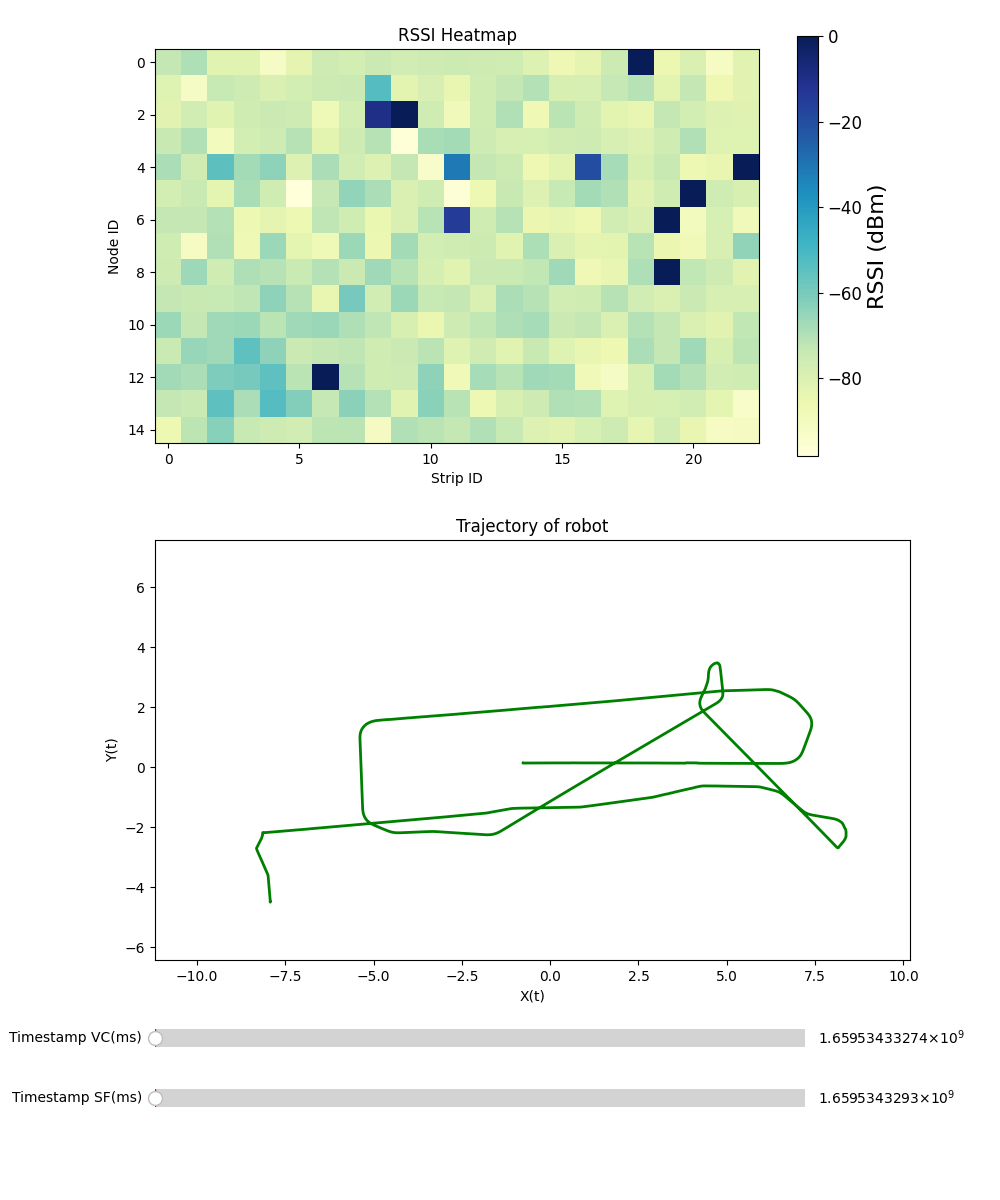

In [21]:
#MERGE RSSI HEATMAP & VICON COORDINATES

#Heatmap animation over the time
from turtle import width
import matplotlib.animation as animation
%matplotlib ipympl
from matplotlib.widgets import Slider, Button, RadioButtons

#DEFINE DATASET ARRAY
x_sf = df_sf_final['strip_id'].to_numpy()
y_sf = df_sf_final['node_id'].to_numpy()
z_sf = df_sf_final['rssi'].to_numpy()
t_sf = df_sf_final['timestamp'].to_numpy()
dataSet_sf = np.array([x_sf, y_sf, z_sf, t_sf])
numDataPoints_sf = len(t_sf)
num_of_nodes = 15
num_of_strips = 23
delta_t_sf = round((t_sf.max()-t_sf.min())/numDataPoints_sf, 6)

#CREATE 3D ARRAY FOR HEATMAP
rssi_mat = np.empty((numDataPoints_sf,15,23))
#fig = plt.figure(figsize=(15, 9))

for index in range(numDataPoints_sf):
    for node in range(num_of_nodes):
        for strip in range(num_of_strips):
            if node == int(dataSet_sf[1][index])-1 and strip == int(dataSet_sf[0][index])-1:
                rssi_mat[index][int(dataSet_sf[1][index])-1][int(dataSet_sf[0][index])-1] = (dataSet_sf[2][index])
            else:
                rssi_mat[index][node][strip] = rssi_mat[index-1][node][strip]

print(dataSet_sf.shape)
#test = np.delete(dataSet_sf, 0, axis=1)
num_del_index = 0

#DATA CLEANING/FILTERING THE DATA THAT BELOW CERTAIN TIMESTAMPS
# for index in range(numDataPoints_sf-1):
#     if dataSet_sf[3][index] < 1659534341:
#        #dataSet_sf = np.delete(dataSet_sf, index, axis=1)
#        num_del_index += 1

# dataSet_sf = np.delete(dataSet_sf, np.s_[0:num_del_index], axis=1)
# numDataPoints_sf = dataSet_sf.shape[1]
# print(dataSet_sf.shape)
# print(dataSet_sf)

#CREATE DATASET FOR VICON COORDINATES
t_vc = df_vicon_final['time'].to_numpy()
x_vc = df_vicon_final['X'].to_numpy()
y_vc = df_vicon_final['Y'].to_numpy()
dataSet_vc = np.array([x_vc, y_vc, t_vc])
numDataPoints_vc = len(t_vc)
delta_t_vc = round((t_vc.max()-t_vc.min())/numDataPoints_vc, 6)

#DATA CLEANING/FILTERING THE DATA THAT BELOW CERTAIN TIMESTAMPS
# for index in range(numDataPoints_vc-1):
#     if dataSet_vc[2][index] < 1659534341.095:
#        #dataSet_sf = np.delete(dataSet_sf, index, axis=1)
#        num_del_index += 1

# dataSet_vc = np.delete(dataSet_vc, np.s_[0:num_del_index], axis=1)
# numDataPoints_vc = dataSet_vc.shape[1]

# GET SOME MATPLOTLIB OBJECTS
#fig, (ax1, ax2) = plt.subplots(figsize=(10,12), nrows=2)
fig = plt.figure(figsize=(10,12))
plt.subplots_adjust(bottom=0.25)


# AXES PROPERTIES RSSI HEATMAP
# plt.title("RSSI Heatmap", fontsize = 16)
# plt.ylabel("Node ID", fontsize = 16)
# plt.xlabel("Strip ID", fontsize = 16)
ax1 = fig.add_subplot(211) #(row, column, pos)
#ax1.set_autoscale_on
ax1.set_xlabel('Strip ID')
ax1.set_ylabel('Node ID')
ax1.set_title('RSSI Heatmap')

# # AXES PROPERTIES VICON COORDINATES
ax2 = fig.add_subplot(212)
ax2.set_xlim(-11.185, 10.185)
ax2.set_ylim(-6.425, 7.575)
ax2.set_xlabel('X(t)')
ax2.set_ylabel('Y(t)')
ax2.set_title('Trajectory of robot')


# Defining the Slider button
# xposition, yposition, width and height
ax_slide_sf = plt.axes([0.155, 0.02, 0.65, 0.03])
ax_slide_vc = plt.axes([0.155, 0.07, 0.65, 0.03])
ax_slide_merge = plt.axes([0.155, 0.12, 0.65, 0.03])

#---------------------------------------------------------RSSI HEATMAP---------------------------------------------------------------------#
# GET SOME MATPLOTLIB OBJECTS
#fig, ax1, ax2 = plt.subplots(figsize=(12, 8))
#plt.subplots_adjust(bottom=0.25)
#line = ax.plot(dataSet[0], dataSet[1], lw=2, c='g')[0] # For line plot 


#DISPLAY INITIAL IMAGE
im_h = ax1.imshow(rssi_mat[numDataPoints_sf-1], cmap="YlGnBu")
cbar = plt.colorbar(im_h, ax=ax1)
cbar.set_label(label='RSSI (dBm)', size=16)
cbar.ax.tick_params(labelsize=12) 

line = ax2.plot(dataSet_vc[0], dataSet_vc[1], lw=2, c='g')[0] # For line plot


# Properties of the slider
#with filtered data
# timestamp_rssi = Slider(ax_slide_sf, 'Timestamp SF(ms)',
#                   dataSet_sf[3].min(), dataSet_sf[3].max(), valinit=dataSet_sf[3].min(), valstep=delta_t_sf)
# timestamp_vc = Slider(ax_slide_vc, 'Timestamp VC(ms)',
#                   dataSet_vc[2].min(), dataSet_vc[2].max(), valinit=dataSet_vc[2].min(), valstep=delta_t_vc)

#normal data
timestamp_rssi = Slider(ax_slide_sf, 'Timestamp SF(ms)',
                  t_sf.min(), t_sf.max(), valinit=t_sf.min(), valstep=delta_t_sf)
timestamp_vc = Slider(ax_slide_vc, 'Timestamp VC(ms)',
                  t_vc.min(), t_vc.max(), valinit=t_vc.min(), valstep=delta_t_vc)
timestamp_merge = Slider(ax_slide_merge, 'Timestamp (ms)',
                  t_vc.min(), t_vc.max(), valinit=t_vc.min(), valstep=delta_t_vc)

# def find_nearest_time(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def update_heatmap(val):
    pos = timestamp_rssi.val
    index = find_nearest(dataSet_sf[3], pos)
    im_h.set_data(rssi_mat[index])

def update_coord(val):
    pos = timestamp_vc.val
    index = find_nearest(dataSet_vc[2], pos)
    line.set_xdata(dataSet_vc[0, :index])
    line.set_ydata(dataSet_vc[1, :index])

    #redrawing the figure
    fig.canvas.draw()    

def update_all(val):
    pos = timestamp_merge.val
    index = find_nearest(dataSet_vc[2], pos)
    line.set_xdata(dataSet_vc[0, :index])
    line.set_ydata(dataSet_vc[1, :index])

    index2 = find_nearest(dataSet_sf[3], pos)
    im_h.set_data(rssi_mat[index2])

    #redrawing the figure
    fig.canvas.draw() 

# Calling the function "update" when the value of the slider is changed
timestamp_rssi.on_changed(update_heatmap)
timestamp_vc.on_changed(update_coord)
timestamp_merge.on_changed(update_all)

#fig.tight_layout()
plt.subplots_adjust(left=0.155, bottom=0.2, right=0.91, top=0.97, hspace=0.2)
#plt.subplot_tool()
plt.show()